# Setup the PEST(++) interface around the enhanced Freyberg model

In this notebook, we will construct a complex model independent (non-intrusive) interface around an existing `MODFLOW-NWT` model using the `python/flopy/pyemu` stack.

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu
import prep_deps
import redis
import matplotlib as mpl
plt.rcParams['font.size']=12
%matplotlib inline
pyemu.__path__

['C:\\Dev\\decision_support_analysis_notebooks\\notebooks\\pyemu']

First we define a base directory `b_d` from which we will read in a model already created `freyberg.nam`. This will form the basis of the remainder of the exercise (and those to follow)

In [2]:
os.getcwd()

'C:\\Dev\\decision_support_analysis_notebooks\\notebooks'

In [3]:
b_d = os.path.join("temp_history")
nam_file = "freyberg.nam"
assert os.path.exists(b_d),"you need to run the setup_transient_history notebook"

### load the existing Freyberg model. This version should run but is not yet connected with `PEST++`

In [4]:
# note that to load a model in a different folder, you supply the namefile without path and supply the path
# to it in the model_ws variable
m = flopy.modflow.Modflow.load(nam_file,model_ws=b_d,check=False,forgive=False)


### some visuals

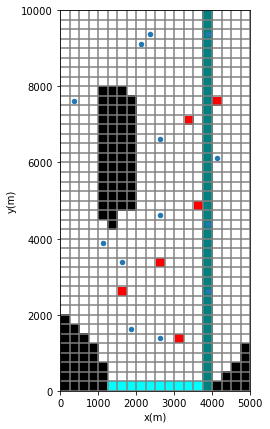

In [5]:
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.PlotMapView(model=m)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
mm.plot_bc("GHB")
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
                  
obs_x = [m.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m.wel.stress_period_data[0]
wel_x = m.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

### we can do a couple `flopy` things to move where the new model will be written

In [6]:
# assign the executable name for the model
m.exe_name = "mfnwt"

# now let's run this in a new folder called temp so we don't overwrite the original data
m.change_model_ws("temp",reset_external=True)

# this writes all the MODFLOW files in the new location 
m.write_input()

# the following helps get the dependecies (both python and executables) in the right place
prep_deps.prep_template(t_d="temp")


changing model workspace...
   temp


### now we can run the model once using a `pyemu` helper
This helper is particularly useful if you run on more than one platform (e.g. Mac and Windows)

In [7]:
pyemu.os_utils.run("{0} {1}".format(m.exe_name,m.name+".nam"),cwd=m.model_ws)

### read in the heads and plot them up along with the budget components
Note that there is a historic period and a scenario with future conditions that differ. 

_For the future scenario, a serious drought, recharge is lower and pumping/abstraction is increased to make up for the presumed deficite in water for agriculture._

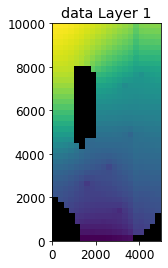

<Figure size 432x288 with 0 Axes>

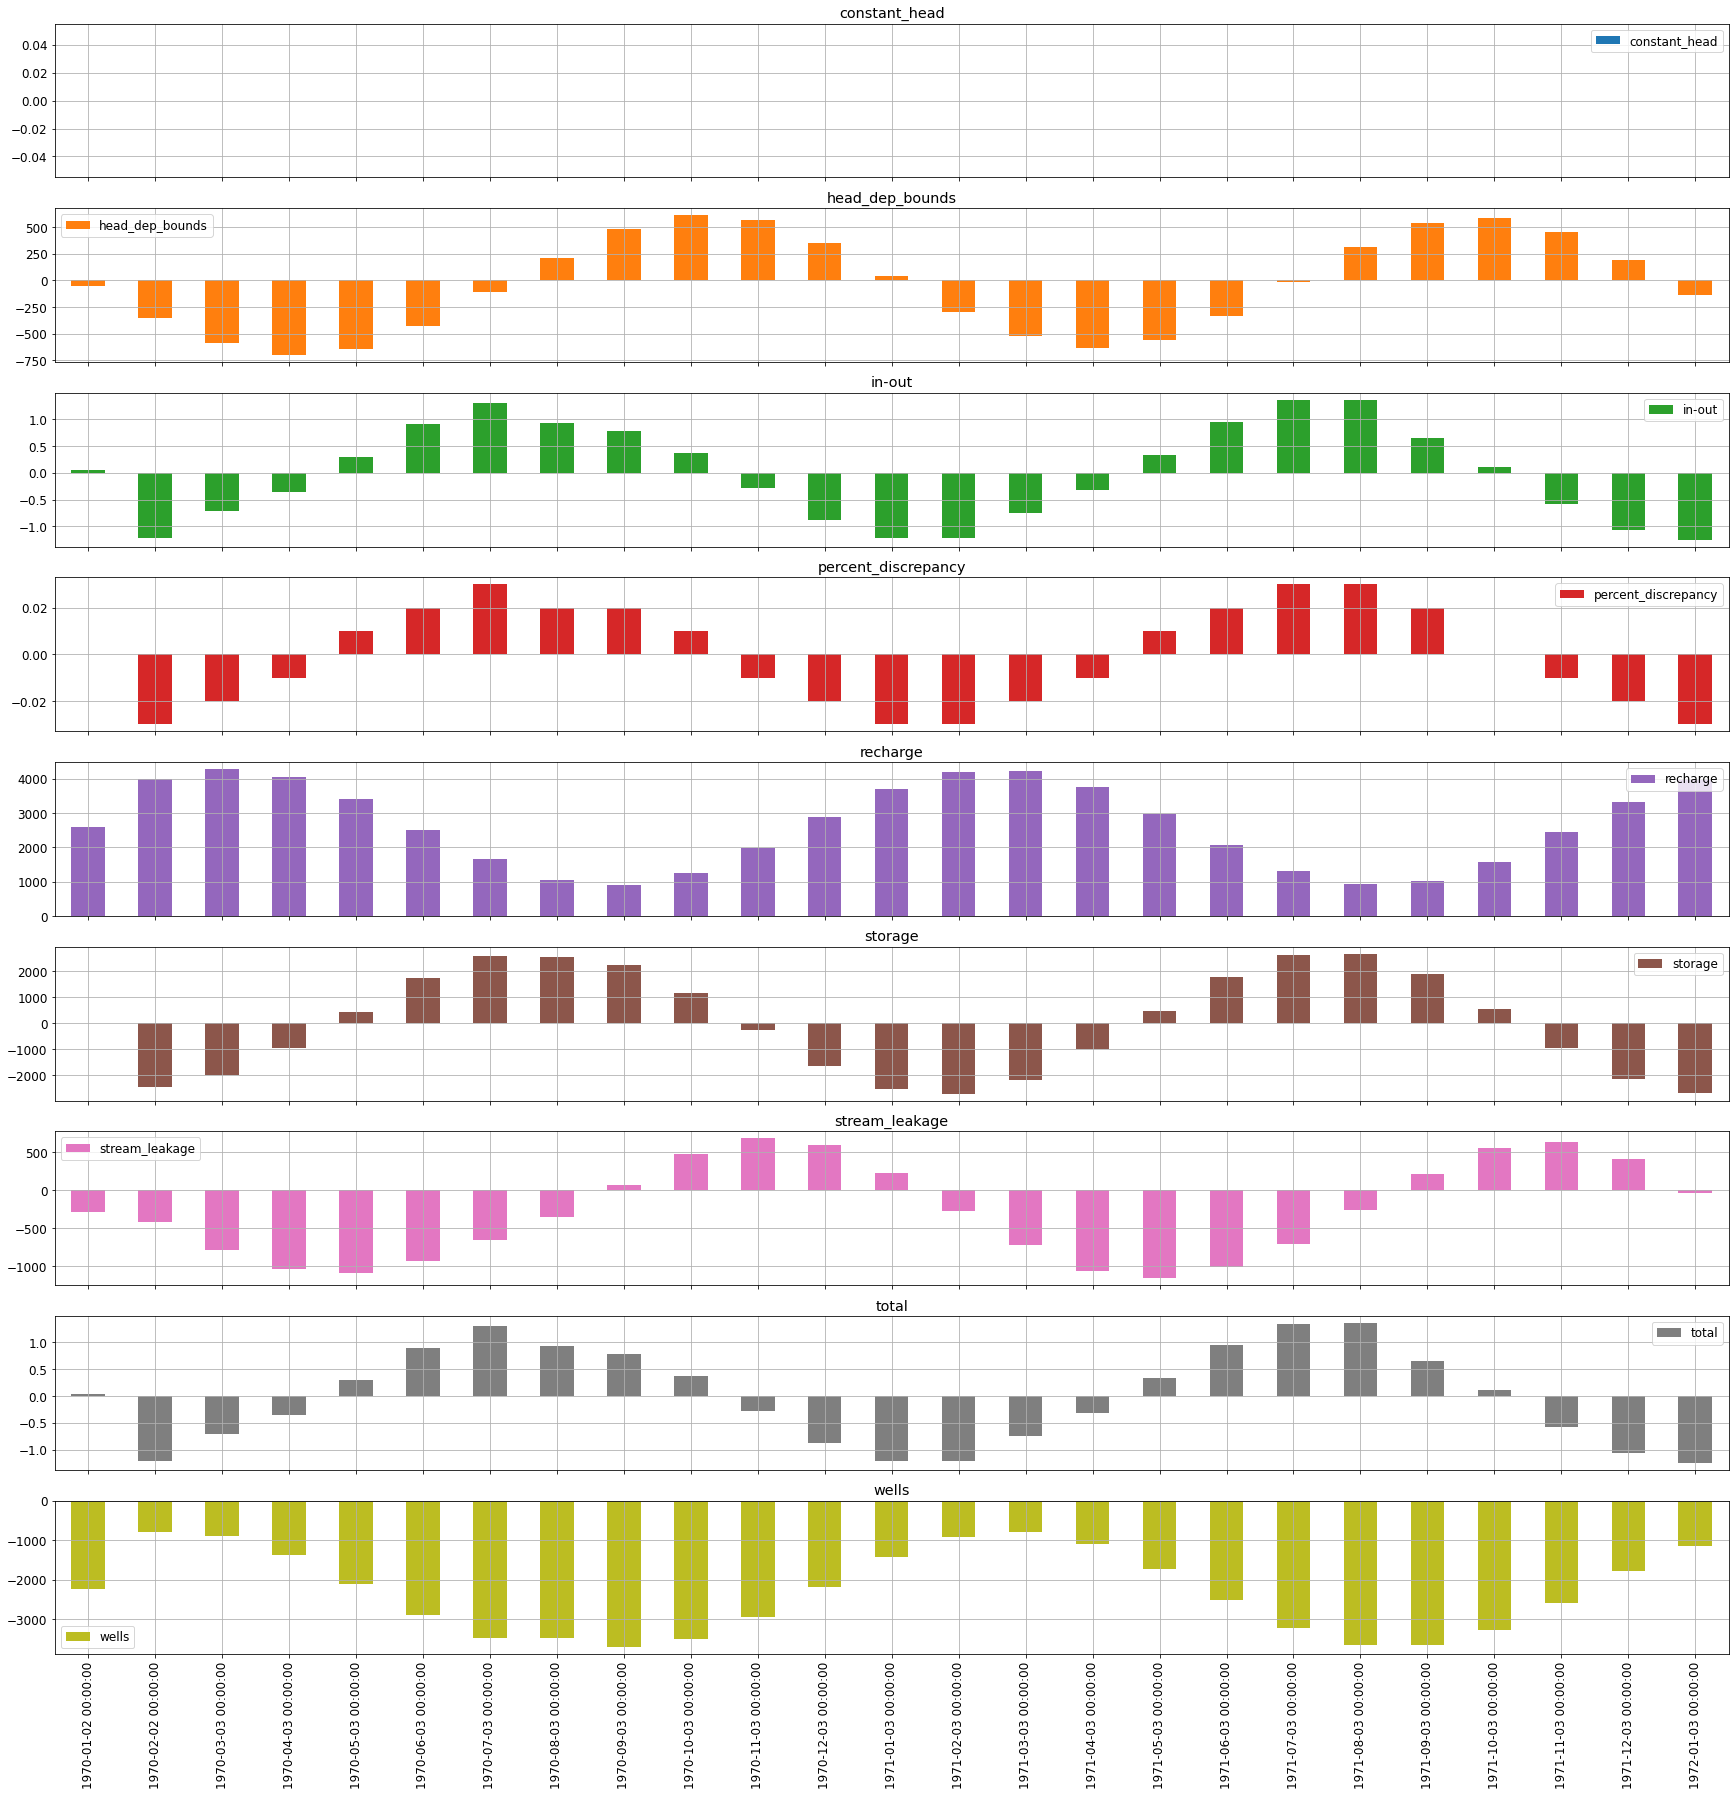

In [8]:
plt.rcParams['font.size']=12
plt.figure()
hds = flopy.utils.HeadFile(os.path.join(m.model_ws,m.name+".hds"),model=m)
hds.plot(mflay=0)
lst = flopy.utils.MfListBudget(os.path.join(m.model_ws,m.name+".list"))
df = lst.get_dataframes(diff=True)[0]
plt.figure()
ax = df.plot(kind="bar",figsize=(30,30), grid=True,subplots=True)

### Plot depth to water

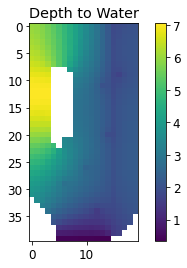

In [9]:
dtw = m.dis.top.array - hds.get_data()[0,:,:]
dtw = np.ma.masked_where(m.bas6.ibound[0].array==0,dtw)
c = plt.imshow(dtw)
plt.title('Depth to Water')
plt.colorbar(c)

we can see the river and well locations expressed in the depth to water pattern.

## Setup data structures related to what we want to parameterize and what we want to observe

## First the parameterization of model inputs. There is a method to the madness. Starting with MODFLOW parameters that are array-style

we can use package/parameter definitions with strings like `'pak.prop'` where `pak` is the abbreviation for a MODFLOW package as interpreted by `flopy` and `prop` is the short abbrevation for a property in the package. For example, `'upw.ss.'` is the specific storage in the Upstream Weighting Package.

For parameters that vary by layer but not by time, we also need to specify which layer (zero-indexed....it's python y'all!) to apply to. So, specify the package/layer combo in a little list like:  
 `['upw.hk', 0]` for `hk` in the `upw` package in layer 0

For parameters that vary by time but not by layer (basically talking recharge here), similar logic is used, except the counter indicates the stress period (still zero-based. still python) like:
`['rch.rech',1]`  is recharge in stress period 1
There is a shortcut for the numbering if you want to specify for all stress periods or all layers (as appropriate). Note that this will apply one set of parameters across layers or stress periods...it will not make distinct parameters for each. Rather than specifying a number, you use the variable `None` like:
`['rch.rech',None]` for recharge across all stress periods or `['upw.ss',None]` for specific storage across all layers

So we are going to do this for a variety of packages/properties in two lists. One `props` will be for packages we want to apply distributed parameters to (e.g. pilot points and grid-based parameters). Then we will add another `constant_props` which will include stress-period based recharge multipliers as well. These will add together as we will see later

In [10]:
props = []
# here we specify which packages we wish to parameterize, 
# starting with those that do not change over time
paks = ["upw.hk","upw.vka","upw.ss","upw.sy","extra.prsity"]  #"extra" because not a modflow parameter
for k in range(m.nlay):
    props.extend([[p,k] for p in paks])
const_props = props.copy()
props.append(["rch.rech",None])
for kper in range(m.nper):
    const_props.append(["rch.rech",kper])
print('props')
props

props


[['upw.hk', 0],
 ['upw.vka', 0],
 ['upw.ss', 0],
 ['upw.sy', 0],
 ['extra.prsity', 0],
 ['upw.hk', 1],
 ['upw.vka', 1],
 ['upw.ss', 1],
 ['upw.sy', 1],
 ['extra.prsity', 1],
 ['upw.hk', 2],
 ['upw.vka', 2],
 ['upw.ss', 2],
 ['upw.sy', 2],
 ['extra.prsity', 2],
 ['rch.rech', None]]

In [11]:
print('const_props')
const_props

const_props


[['upw.hk', 0],
 ['upw.vka', 0],
 ['upw.ss', 0],
 ['upw.sy', 0],
 ['extra.prsity', 0],
 ['upw.hk', 1],
 ['upw.vka', 1],
 ['upw.ss', 1],
 ['upw.sy', 1],
 ['extra.prsity', 1],
 ['upw.hk', 2],
 ['upw.vka', 2],
 ['upw.ss', 2],
 ['upw.sy', 2],
 ['extra.prsity', 2],
 ['rch.rech', 0],
 ['rch.rech', 1],
 ['rch.rech', 2],
 ['rch.rech', 3],
 ['rch.rech', 4],
 ['rch.rech', 5],
 ['rch.rech', 6],
 ['rch.rech', 7],
 ['rch.rech', 8],
 ['rch.rech', 9],
 ['rch.rech', 10],
 ['rch.rech', 11],
 ['rch.rech', 12],
 ['rch.rech', 13],
 ['rch.rech', 14],
 ['rch.rech', 15],
 ['rch.rech', 16],
 ['rch.rech', 17],
 ['rch.rech', 18],
 ['rch.rech', 19],
 ['rch.rech', 20],
 ['rch.rech', 21],
 ['rch.rech', 22],
 ['rch.rech', 23],
 ['rch.rech', 24]]

## Now we can handle MDOFLOW list-style parameters in two ways
for `spatial_list_props` this will apply a multiplier distributed spatially that applied in all stress periods throughout the model

for `temporal_list_props` this will apply a multiplier for each stress period applied to all the spatial locations

In [12]:
spatial_list_props = [["wel.flux",2],["ghb.cond",0],["ghb.cond",1],["ghb.cond",2]]  # spatially by each list entry, across all stress periods
temporal_list_props = [["wel.flux",kper] for kper in range(m.nper)]  # spatially uniform for each stress period
print(spatial_list_props)
temporal_list_props

[['wel.flux', 2], ['ghb.cond', 0], ['ghb.cond', 1], ['ghb.cond', 2]]


[['wel.flux', 0],
 ['wel.flux', 1],
 ['wel.flux', 2],
 ['wel.flux', 3],
 ['wel.flux', 4],
 ['wel.flux', 5],
 ['wel.flux', 6],
 ['wel.flux', 7],
 ['wel.flux', 8],
 ['wel.flux', 9],
 ['wel.flux', 10],
 ['wel.flux', 11],
 ['wel.flux', 12],
 ['wel.flux', 13],
 ['wel.flux', 14],
 ['wel.flux', 15],
 ['wel.flux', 16],
 ['wel.flux', 17],
 ['wel.flux', 18],
 ['wel.flux', 19],
 ['wel.flux', 20],
 ['wel.flux', 21],
 ['wel.flux', 22],
 ['wel.flux', 23],
 ['wel.flux', 24]]

## Now for model outputs

next we want to set up the extraction of model outputs that are of interest, not just places where we have state observations. In many cases we are interested in dry conditions and also the last stress period.  So lets include simulated water levels from a dry stress period and from the last stress period.  The container `hds_kperk` is a nested list of stress period and layer pairs from which we want to `observe` (in the PEST control file sense) the simulated water levels from (all active cells are included)

In [13]:
dry_kper = int(m.nper * 0.85) # the "dry" season in the last annual cycle
hds_kperk = [[kper,k] for k in range(m.nlay) for kper in [0,dry_kper,m.nper-1]]
#hds_kperk.extend([[1,k] for k in range(m.nlay)])
hds_kperk

[[0, 0], [21, 0], [24, 0], [0, 1], [21, 1], [24, 1], [0, 2], [21, 2], [24, 2]]

### then we setup monitoring of the SFR ASCII outputs.  
we will accumulate the first 20 reaches and last 20 reaches (corresponding to the top and bottom half of the model, respectively) together to form forecasts of sw-gw exchange in the headwaters (`hw`) and tailwaters (`tw`).  We will also include the most downstream reach since that is where we have surface-water flow state observations for history matching.  The container `sft_obs_dict` will help us setup PEST `observations`.  Then later we will have to assign actual observation data to these quantities.

In [14]:
sfr_obs_dict = {}
sfr_obs_dict["hw"] = np.arange(1,int(m.nrow/2))
sfr_obs_dict["tw"] = np.arange(int(m.nrow/2),m.nrow)
sfr_obs_dict["gage_1"] = [39]
#for i in range(m.nrow):
#    sfr_obs_dict[i] = i+1

### here we go...

This `pyemu` class has grown into a monster...it does (among other things):
- sets up combinations of multiplier parameters for array inputs, including uniform, zones, pilot points, grids, and KL expansion types
- sets up combinations of multiplier parameters for list inputs
- handles several of the shitty modflow exceptions to the array and list style inputs
- sets up large numbers of observations based on arrays or time series
- writes .tpl, .ins, .pst, etc
- writes a python forward run script
- writes a prior parameter covaraince matrix using geostatistical correlations
- draws from the prior parameter covariance matrix to generate a prior parameter ensemble

WAT?!

This will be slow because the pure python kriging...but, hey, its free!

For our purposes, we will setup combinations of constant (by layer), pilot points and grid-scale parameters for each of the array-based properties we defined earlier.  This lets us explore options for parameterization and also start to understand how information flows in the history matching problem


In [15]:
pst_helper = pyemu.helpers.PstFromFlopyModel(nam_file,new_model_ws="template_history",org_model_ws="temp",
                                             const_props=const_props,
                                             spatial_list_props=spatial_list_props,
                                             temporal_list_props=temporal_list_props,
                                             remove_existing=True,
                                             pp_props=props,
                                             grid_props=props,
                                             sfr_pars=["strk"],
                                             hds_kperk=hds_kperk,
                                             sfr_obs=sfr_obs_dict,
                                             build_prior=False,
                                             model_exe_name="mfnwt",
                                             pp_space=4)
prep_deps.prep_template(t_d=pst_helper.new_model_ws)

2020-12-17 08:21:50.517293 starting: loading flopy model

Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> temp\freyberg.nam

--------------------------------------------------
External unit dictionary:
{2: filename:temp\freyberg.list, filetype:LIST, 11: filename:temp\freyberg.dis, filetype:DIS, 13: filename:temp\freyberg.bas, filetype:BAS6, 31: filename:temp\freyberg.upw, filetype:UPW, 32: filename:temp\freyberg.nwt, filetype:NWT, 14: filename:temp\freyberg.oc, filetype:OC, 20: filename:temp\freyberg.wel, filetype:WEL, 19: filename:temp\freyberg.rch, filetype:RCH, 23: filename:temp\freyberg.ghb, filetype:GHB, 17: filename:temp\freyberg.sfr, filetype:SFR, 50: filename:temp\freyberg.cbc, filetype:DATA(BINARY), 51: filename:temp\freyberg.hds, filetype:DATA(BINARY), 60: filename:temp\freyberg.sfr.out, filetype:DATA}
--------------------------------------------------

ModflowBas6 free format:True

loading dis package file..

 
2020-12-17 08:21:52.271252 finished: writing new modflow input files took: 0:00:00.297494
2020-12-17 08:21:52.271252 forward_run line:pyemu.os_utils.run('mfnwt freyberg.nam 1>freyberg.nam.stdout 2>freyberg.nam.stderr')
2020-12-17 08:21:52.271252 starting: setting up 'template_history\arr_org' dir
2020-12-17 08:21:52.271252 finished: setting up 'template_history\arr_org' dir took: 0:00:00
2020-12-17 08:21:52.271252 starting: setting up 'template_history\arr_mlt' dir
2020-12-17 08:21:52.271252 finished: setting up 'template_history\arr_mlt' dir took: 0:00:00
2020-12-17 08:21:52.271252 starting: setting up 'template_history\list_org' dir
2020-12-17 08:21:52.271252 finished: setting up 'template_history\list_org' dir took: 0:00:00
2020-12-17 08:21:52.271252 starting: setting up 'template_history\list_mlt' dir
2020-12-17 08:21:52.271252 finished: setting up 'template_history\list_mlt' dir took: 0:00:00
2020-12-17 08:21:52.271252 starting: processing temporal_list_props
2020-12-17 08:21:52

C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity3000000
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity3000001
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity3000002
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity3000003
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity3000004
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity3000005
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpe

2020-12-17 08:21:53.776463 starting: writing grid tpl:vka5.dat_gr.tpl
2020-12-17 08:21:53.787863 finished: writing grid tpl:vka5.dat_gr.tpl took: 0:00:00.011400
2020-12-17 08:21:53.787863 starting: writing grid tpl:ss5.dat_gr.tpl
2020-12-17 08:21:53.792111 finished: writing grid tpl:ss5.dat_gr.tpl took: 0:00:00.004248
2020-12-17 08:21:53.792111 starting: writing grid tpl:sy5.dat_gr.tpl
2020-12-17 08:21:53.807713 finished: writing grid tpl:sy5.dat_gr.tpl took: 0:00:00.015602
2020-12-17 08:21:53.807713 starting: writing grid tpl:prsity5.dat_gr.tpl
2020-12-17 08:21:53.870213 finished: writing grid tpl:prsity5.dat_gr.tpl took: 0:00:00.062500
2020-12-17 08:21:53.870213 starting: writing grid tpl:rech1.dat_gr.tpl
2020-12-17 08:21:53.888080 finished: writing grid tpl:rech1.dat_gr.tpl took: 0:00:00.017867
2020-12-17 08:21:53.888080 starting: writing const tpl:hk6.dat_cn.tpl
2020-12-17 08:21:53.888080 finished: writing const tpl:hk6.dat_cn.tpl took: 0:00:00
2020-12-17 08:21:53.888080 starting: 

C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity5000000
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity5000001
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity5000002
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity5000003
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity5000004
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpers.py:4163: UserWarning: grid pname too long for pest:prsity5000005
  warnings.warn(
C:\Dev\decision_support_analysis_notebooks\notebooks\pyemu\utils\helpe

2020-12-17 08:21:53.963988 finished: writing const tpl:ss8.dat_cn.tpl took: 0:00:00
2020-12-17 08:21:53.963988 starting: writing const tpl:sy8.dat_cn.tpl
2020-12-17 08:21:53.963988 finished: writing const tpl:sy8.dat_cn.tpl took: 0:00:00
2020-12-17 08:21:53.963988 starting: writing const tpl:prsity8.dat_cn.tpl
2020-12-17 08:21:53.979783 finished: writing const tpl:prsity8.dat_cn.tpl took: 0:00:00.015795
2020-12-17 08:21:53.979783 starting: writing const tpl:rech2.dat_cn.tpl
2020-12-17 08:21:53.988433 finished: writing const tpl:rech2.dat_cn.tpl took: 0:00:00.008650
2020-12-17 08:21:53.988433 starting: writing const tpl:rech3.dat_cn.tpl
2020-12-17 08:21:53.995430 finished: writing const tpl:rech3.dat_cn.tpl took: 0:00:00.006997
2020-12-17 08:21:53.995430 starting: writing const tpl:rech4.dat_cn.tpl
2020-12-17 08:21:53.995430 finished: writing const tpl:rech4.dat_cn.tpl took: 0:00:00
2020-12-17 08:21:53.995430 starting: writing const tpl:rech5.dat_cn.tpl
2020-12-17 08:21:54.011308 finish

C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


took 4.589117 seconds
2020-12-17 08:21:59.145043 finished: calculating factors for p=hk0, k=0 took: 0:00:04.636651
2020-12-17 08:21:59.145043 starting: calculating factors for p=prsity0, k=0
2020-12-17 08:21:59.145043 finished: calculating factors for p=prsity0, k=0 took: 0:00:00
2020-12-17 08:21:59.145043 starting: calculating factors for p=rech0, k=0
2020-12-17 08:21:59.145043 finished: calculating factors for p=rech0, k=0 took: 0:00:00
2020-12-17 08:21:59.159968 starting: calculating factors for p=ss0, k=0
2020-12-17 08:21:59.159968 finished: calculating factors for p=ss0, k=0 took: 0:00:00
2020-12-17 08:21:59.159968 starting: calculating factors for p=sy0, k=0
2020-12-17 08:21:59.159968 finished: calculating factors for p=sy0, k=0 took: 0:00:00
2020-12-17 08:21:59.159968 starting: calculating factors for p=vka0, k=0
2020-12-17 08:21:59.159968 finished: calculating factors for p=vka0, k=0 took: 0:00:00
2020-12-17 08:21:59.159968 starting: calculating factors for p=hk1, k=1
2020-12-1

C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


took 4.469548 seconds
2020-12-17 08:22:03.676886 finished: calculating factors for p=hk1, k=1 took: 0:00:04.516918
2020-12-17 08:22:03.676886 starting: calculating factors for p=prsity1, k=1
2020-12-17 08:22:03.676886 finished: calculating factors for p=prsity1, k=1 took: 0:00:00
2020-12-17 08:22:03.676886 starting: calculating factors for p=ss1, k=1
2020-12-17 08:22:03.676886 finished: calculating factors for p=ss1, k=1 took: 0:00:00
2020-12-17 08:22:03.676886 starting: calculating factors for p=sy1, k=1
2020-12-17 08:22:03.676886 finished: calculating factors for p=sy1, k=1 took: 0:00:00
2020-12-17 08:22:03.676886 starting: calculating factors for p=vka1, k=1
2020-12-17 08:22:03.676886 finished: calculating factors for p=vka1, k=1 took: 0:00:00
2020-12-17 08:22:03.676886 starting: calculating factors for p=hk2, k=2
2020-12-17 08:22:03.690417 saving krige variance file:template_history\pp_k2_general_zn.var.dat
2020-12-17 08:22:03.690417 saving krige factors file:template_history\pp_k2

C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


took 4.707035 seconds
2020-12-17 08:22:08.429964 finished: calculating factors for p=hk2, k=2 took: 0:00:04.753078
2020-12-17 08:22:08.429964 starting: calculating factors for p=prsity2, k=2
2020-12-17 08:22:08.429964 finished: calculating factors for p=prsity2, k=2 took: 0:00:00
2020-12-17 08:22:08.429964 starting: calculating factors for p=ss2, k=2
2020-12-17 08:22:08.445496 finished: calculating factors for p=ss2, k=2 took: 0:00:00.015532
2020-12-17 08:22:08.445496 starting: calculating factors for p=sy2, k=2
2020-12-17 08:22:08.445496 finished: calculating factors for p=sy2, k=2 took: 0:00:00
2020-12-17 08:22:08.445496 starting: calculating factors for p=vka2, k=2
2020-12-17 08:22:08.445496 finished: calculating factors for p=vka2, k=2 took: 0:00:00
2020-12-17 08:22:08.445496 starting: processing pp_prefix:hk0
2020-12-17 08:22:08.445496 starting: processing pp_prefix:prsity0
2020-12-17 08:22:08.445496 starting: processing pp_prefix:rech0
2020-12-17 08:22:08.461250 starting: process

finished fac2real 2020-12-17 08:22:10.914875
starting arr mlt 2020-12-17 08:22:10.914875
finished arr mlt 2020-12-17 08:22:13.492490
2020-12-17 08:22:13.507256 forward_run line:pyemu.helpers.apply_array_pars()

2020-12-17 08:22:13.570048 starting: processing obs type mflist water budget obs
2020-12-17 08:22:13.791044 forward_run line:pyemu.gw_utils.apply_mflist_budget_obs('freyberg.list',flx_filename='flux.dat',vol_filename='vol.dat',start_datetime='12-31-2015')
2020-12-17 08:22:13.791044 finished: processing obs type mflist water budget obs took: 0:00:00.220996
2020-12-17 08:22:13.791044 starting: processing obs type hyd file
2020-12-17 08:22:13.791044 finished: processing obs type hyd file took: 0:00:00
2020-12-17 08:22:13.791044 starting: processing obs type external obs-sim smp files
2020-12-17 08:22:13.791044 finished: processing obs type external obs-sim smp files took: 0:00:00
2020-12-17 08:22:13.791044 starting: processing obs type hob
2020-12-17 08:22:13.791044 finished: proce

Take some time to inspect the `template_history` directory that was just created in the same directory where this notebook is running.  You should find a pest control file names `freyberg.pst`, heaps of PEST-style template and instruction files and a python script named `forward_run.py`.  Let's checkout this script:

In [16]:
[print(i.rstrip()) for i in open('template_history/forward_run.py','r').readlines()];

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import flopy
import pyemu
def main():

    try:
       os.remove('freyberg.list')
    except Exception as e:
       print('error removing tmp file:freyberg.list')
    try:
       os.remove('freyberg.hds')
    except Exception as e:
       print('error removing tmp file:freyberg.hds')
    pyemu.helpers.apply_list_pars()

    pyemu.helpers.apply_array_pars()

    pyemu.os_utils.run('mfnwt freyberg.nam 1>freyberg.nam.stdout 2>freyberg.nam.stderr')
    pyemu.gw_utils.apply_mflist_budget_obs('freyberg.list',flx_filename='flux.dat',vol_filename='vol.dat',start_datetime='12-31-2015')
    pyemu.gw_utils.apply_hds_obs('freyberg.hds')
    pyemu.gw_utils.apply_sfr_obs()

if __name__ == '__main__':
    mp.freeze_support()
    main()



So that `pst_helper` instance wrote this python script - WAT?!  Each time one of the PEST++ tools "runs the model", it will call this script, which will handle the required pre-processing to construct MODFLOW input files, run MODFLOW, and post-process the MODFLOW output files into files that PEST can read (with the instruction files).

### Investigating the `pst_helper` instance

The `pst_helper` instance contains the `pyemu.Pst` instance:

In [17]:
# so, pull out the `pyemu.Pst` instance which 
#contains all the input that ultimately goes in the PEST control %%file
pst = pst_helper.pst
pst.npar,pst.nobs

(11913, 6945)

### Oh snap!

`pyemu` uses `pandas` data frame format for the parameter and observation data sections. This offers plenty of querying and bulk editing options.

Let's stop for a moment to get a better feel for what just happened! Let's dig in..

In [18]:
# check out hydraulic conductivity parameters
pst.parameter_data.loc[pst.parameter_data.parnme.str.contains('hk'),:]

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
const_hk6__cn,const_hk6__cn,log,factor,1.0,0.10,10.0,cn_hk6,1.0,0.0,1
const_hk7__cn,const_hk7__cn,log,factor,1.0,0.10,10.0,cn_hk7,1.0,0.0,1
const_hk8__cn,const_hk8__cn,log,factor,1.0,0.10,10.0,cn_hk8,1.0,0.0,1
hk0_00,hk0_00,log,factor,1.0,0.01,100.0,pp_hk0,1.0,0.0,1
hk0_01,hk0_01,log,factor,1.0,0.01,100.0,pp_hk0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
hk5039010,hk5039010,log,factor,1.0,0.01,100.0,gr_hk5,1.0,0.0,1
hk5039011,hk5039011,log,factor,1.0,0.01,100.0,gr_hk5,1.0,0.0,1
hk5039012,hk5039012,log,factor,1.0,0.01,100.0,gr_hk5,1.0,0.0,1
hk5039013,hk5039013,log,factor,1.0,0.01,100.0,gr_hk5,1.0,0.0,1


In [19]:
# what about observations? in particular, the sfr flow-out observations?
pst.observation_data.loc[pst.observation_data.obgnme.apply(lambda x: "flout" in x),:]

,obsnme,obsval,weight,obgnme
fo_gage_1_20160101,fo_gage_1_20160101,10289.0,1.0,flout
fo_gage_1_20160201,fo_gage_1_20160201,15882.0,1.0,flout
fo_gage_1_20160301,fo_gage_1_20160301,17279.0,1.0,flout
fo_gage_1_20160401,fo_gage_1_20160401,16669.0,1.0,flout
fo_gage_1_20160501,fo_gage_1_20160501,14216.0,1.0,flout
...,...,...,...,...
fo_tw_20170901,fo_tw_20170901,78352.9,1.0,flout
fo_tw_20171001,fo_tw_20171001,115957.7,1.0,flout
fo_tw_20171101,fo_tw_20171101,180555.9,1.0,flout
fo_tw_20171201,fo_tw_20171201,253215.0,1.0,flout


You can see we have flow-out `observations` (in the PEST sense) for "gage_1", tailwaters ("tw") and headwaters ("hw"). Let's give these observations more meaningful group names (the `obgnme` attribute)

In [20]:
obs = pst.observation_data
flout_obs = obs.loc[obs.obgnme.apply(lambda x: "flout" in x),"obsnme"]
obs.loc[flout_obs,"obgnme"] = flout_obs.apply(lambda x: "_".join(x.split('_')[:-1]))
obs.loc[flout_obs,"obgnme"].unique()

array(['fo_gage_1', 'fo_hw', 'fo_tw'], dtype=object)

### Add time-series based observations

We need to track specific head locations across all times for transient state observations that have been "measured".  To setup the tracking, we need to know where (lay-row-col) the observations are located

In [21]:
obs_locs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
#build obs names that correspond to the obsnme values in the control file
obs_locs.loc[:,"site"] = obs_locs.apply(lambda x: "trgw_{0:03d}_{1:03d}".format(x.row-1,x.col-1),axis=1)
kij_dict = {site:(2,r-1,c-1) for site,r,c in zip(obs_locs.site,obs_locs.row,obs_locs.col)}
obs_locs

,row,col,site
0,3,16,trgw_002_015
1,3,10,trgw_002_009
2,4,9,trgw_003_008
3,10,2,trgw_009_001
4,14,11,trgw_013_010
5,16,17,trgw_015_016
6,22,11,trgw_021_010
7,23,16,trgw_022_015
8,25,5,trgw_024_004
9,27,7,trgw_026_006


In [22]:
kij_dict

{'trgw_002_015': (2, 2, 15),
 'trgw_002_009': (2, 2, 9),
 'trgw_003_008': (2, 3, 8),
 'trgw_009_001': (2, 9, 1),
 'trgw_013_010': (2, 13, 10),
 'trgw_015_016': (2, 15, 16),
 'trgw_021_010': (2, 21, 10),
 'trgw_022_015': (2, 22, 15),
 'trgw_024_004': (2, 24, 4),
 'trgw_026_006': (2, 26, 6),
 'trgw_029_015': (2, 29, 15),
 'trgw_033_007': (2, 33, 7),
 'trgw_034_010': (2, 34, 10)}

We can use a `pyemu` groundwater utility to setup the transient groundwater level monitoring for us.  We need that location dictionary from above and the name of the binary file to process (the MODFLOW "head save" file).  Important: only run this code block once!!!

In [23]:
binary_file = os.path.join(pst_helper.m.model_ws,nam_file.replace(".nam",".hds"))
frun_line,tr_hds_df = pyemu.gw_utils.setup_hds_timeseries(binary_file,kij_dict=kij_dict,include_path=True,model=pst_helper.m)
pst_helper.frun_post_lines.append(frun_line)
print(frun_line.strip());

writing config file to template_history\freyberg.hds_timeseries.config
writing instruction file to template_history\freyberg.hds_timeseries.processed.ins
pyemu.gw_utils.apply_hds_timeseries('freyberg.hds_timeseries.config',None)


You can see that the `frun_line` is in fact a valid line of python code - we added it to the `pst_helper` container for post-processing forward-run script lines:

In [24]:
[print(i.strip()) for i in pst_helper.frun_post_lines];

pyemu.gw_utils.apply_mflist_budget_obs('freyberg.list',flx_filename='flux.dat',vol_filename='vol.dat',start_datetime='12-31-2015')
pyemu.gw_utils.apply_hds_obs('freyberg.hds')
pyemu.gw_utils.apply_sfr_obs()
pyemu.gw_utils.apply_hds_timeseries('freyberg.hds_timeseries.config',None)


We can also see the `tr_hds_df` is a dataframe of the simulated groundwater levels extracted from the head save file,
with other PEST-relevant columns. The `obsval` is the extracted simulated groundwater levels, the `obsnme` is the PEST observation names (encoded as `<site>_<datetime>`).  And since we added the row and col to the site names, we now have the metadata nessecary to understand where in space and in time these observations are - sweet as!

In [25]:
tr_hds_df.head()

,obsval,weight,obgnme
trgw_002_009_20160101,35.139503,0.0,trgw
trgw_002_009_20160201,35.243200,0.0,trgw
trgw_002_009_20160301,35.334640,0.0,trgw
trgw_002_009_20160401,35.387127,0.0,trgw
trgw_002_009_20160501,35.376064,0.0,trgw


Now we need to add these new (PEST) "obseravtions" to the control file.  To do that, we need the instruction file (which as also written by that nice setup routine - so thoughtful!)

In [26]:
[f for f in os.listdir(pst_helper.m.model_ws) if f.endswith(".ins")]

['flux.dat.ins',
 'freyberg.hds.dat.ins',
 'freyberg.hds_timeseries.processed.ins',
 'freyberg.sfr.out.processed.ins',
 'vol.dat.ins']

We will use the `pyemu.Pst.add_observations` method for this.  Important: only run this block once!!!

In [27]:
df = pst_helper.pst.add_observations(os.path.join(pst_helper.m.model_ws,
                nam_file.replace(".nam",".hds_timeseries.processed.ins")),pst_path=".")
obs = pst_helper.pst.observation_data
obs.loc[df.index,"obgnme"] = df.index.map(lambda x: "_".join(x.split("_")[:-1]))
obs.loc[df.index,"weight"] = 1.0
obs.loc[df.index,"obgnme"].unique()

325 obs added from instruction file template_history\.\freyberg.hds_timeseries.processed.ins


array(['trgw_002_015', 'trgw_002_009', 'trgw_003_008', 'trgw_009_001',
       'trgw_013_010', 'trgw_015_016', 'trgw_021_010', 'trgw_022_015',
       'trgw_024_004', 'trgw_026_006', 'trgw_029_015', 'trgw_033_007',
       'trgw_034_010'], dtype=object)

There are our new transient groundwater level observation groups.  

### Add modpath input files, instruction files and calls

First copy over all the MODPATH-related files from the base directory identified in the `b_d` variable.   We will track a single particle for forecast purposes

In [28]:
mp_files = [f for f in os.listdir(b_d) if "mp" in f or "location" in f]
[shutil.copy2(os.path.join(b_d,f),os.path.join(pst_helper.new_model_ws,f)) for f in mp_files]

['template_history\\freyberg.locations',
 'template_history\\freyberg.mpbas',
 'template_history\\freyberg.mpenpt',
 'template_history\\freyberg.mplist',
 'template_history\\freyberg.mpnam',
 'template_history\\freyberg.mppthln',
 'template_history\\freyberg.mpsim',
 'template_history\\mp6.exe',
 'template_history\\mp_ibound_1.ref',
 'template_history\\mp_ibound_2.ref',
 'template_history\\mp_ibound_3.ref']

The following `frun_post_lines` property adds statements at the end of the `forward_run.py` script. In this case, it runs MODPATH using `mp6`.  We will also identify any additional temporary files that the forward run script will attempt to remove at the start of a run.

In [29]:
#pst_helper.frun_post_lines.append("os.system('mp6 freyberg.mpsim >mp6.stdout')")
pst_helper.frun_post_lines.append("pyemu.os_utils.run('mp6 freyberg.mpsim >mp6.stdout')")
pst_helper.tmp_files.append("freyberg.mpenpt")  # placed at top of `forward_run.py`


Since we have added new commands for the forward run process, we need to re-write the `forward_run.py` script:

In [30]:
pst_helper.write_forward_run()

Let's see how it changed:

In [31]:
[print(i.rstrip()) for i in open('template_history/forward_run.py','r').readlines()];

import os
import multiprocessing as mp
import numpy as np
import pandas as pd
import flopy
import pyemu
def main():

    try:
       os.remove('freyberg.list')
    except Exception as e:
       print('error removing tmp file:freyberg.list')
    try:
       os.remove('freyberg.hds')
    except Exception as e:
       print('error removing tmp file:freyberg.hds')
    try:
       os.remove('freyberg.mpenpt')
    except Exception as e:
       print('error removing tmp file:freyberg.mpenpt')
    pyemu.helpers.apply_list_pars()

    pyemu.helpers.apply_array_pars()

    pyemu.os_utils.run('mfnwt freyberg.nam 1>freyberg.nam.stdout 2>freyberg.nam.stderr')
    pyemu.gw_utils.apply_mflist_budget_obs('freyberg.list',flx_filename='flux.dat',vol_filename='vol.dat',start_datetime='12-31-2015')
    pyemu.gw_utils.apply_hds_obs('freyberg.hds')
    pyemu.gw_utils.apply_sfr_obs()
    pyemu.gw_utils.apply_hds_timeseries('freyberg.hds_timeseries.config',None)

    pyemu.os_utils.run('mp6 freyberg.mpsim >mp

Sweet!  now we have added the MODPATH bits to this script.

Now we need to create and add an instruction file and related observations for MODPATH - we will track a single particle released need the western groundwater divide and use both its travel time and particle status as "observations" in the control file (well, actually, we will use these two quantities as forecasts!)

In [32]:
# write a really simple instruction file to read the MODPATH end point file
out_file = "freyberg.mpenpt"
ins_file = out_file + ".ins"
with open(os.path.join(pst_helper.new_model_ws,ins_file),'w') as f:
    f.write("pif ~\n")
    f.write("l7 w w w !part_status! w w !part_time!\n")

Just like before, we need to add these "observations" to our pest control file:

In [33]:
df = pst_helper.pst.add_observations(os.path.join(pst_helper.new_model_ws,ins_file),
                                     os.path.join(pst_helper.new_model_ws,out_file),
                                     pst_path=".")

2 obs added from instruction file template_history\.\freyberg.mpenpt.ins


We also need to copy the original prsity arrays to the `arr_org` dir for use in the multiplier parameterization scheme

In [34]:
for k in range(m.nlay):
    np.savetxt(os.path.join(pst_helper.new_model_ws,"arr_org","prsity_layer_{0}.ref".format(k+1)),
               np.zeros((m.nrow,m.ncol))+0.0005,fmt="%15.6E")

### Final bits and bobs
We need to set some realistic parameter bounds and account for expected (but stochastic) values:

In [35]:
par = pst.parameter_data  # we inspected this guy earlier
# properties
tag_dict = {"hk":[0.1,10.0],"vka":[0.1,10],"pr":[0.5,1.5],"rech":[0.7,1.3]}
for t,[l,u] in tag_dict.items():
    t_pars = par.loc[par.parnme.apply(lambda x: t in x ),"parnme"]
    par.loc[t_pars,"parubnd"] = u
    par.loc[t_pars,"parlbnd"] = l

given the combinations of multipliers, we need to set a hard upper bound on `sy` and `prsity` since they have physical upper limit (note: seperate to bounds handled explicitly by pest).  This is how you set bounds on the actual model input arrays that MODFLOW will use:

In [36]:
arr_csv = os.path.join(pst_helper.new_model_ws,"arr_pars.csv")
df = pd.read_csv(arr_csv,index_col=0)
df.head()

,org_file,mlt_file,model_file,layer,suffix,prefix,attr_name,tpl_file,fac_file,pp_file
0,arr_org\hk_Layer_1.ref,arr_mlt\hk0.dat_pp,.\hk_Layer_1.ref,0,_pp,hk0,hk,NaN,pp_k0_general_zn.fac,hk0pp.dat
1,arr_org\vka1.ref,arr_mlt\vka0.dat_pp,.\vka1.ref,0,_pp,vka0,vka,NaN,pp_k0_general_zn.fac,vka0pp.dat
2,arr_org\ss_Layer_1.ref,arr_mlt\ss0.dat_pp,.\ss_Layer_1.ref,0,_pp,ss0,ss,NaN,pp_k0_general_zn.fac,ss0pp.dat
3,arr_org\sy_Layer_1.ref,arr_mlt\sy0.dat_pp,.\sy_Layer_1.ref,0,_pp,sy0,sy,NaN,pp_k0_general_zn.fac,sy0pp.dat
4,arr_org\prsity_layer_1.ref,arr_mlt\prsity0.dat_pp,.\prsity_layer_1.ref,0,_pp,prsity0,prsity,NaN,pp_k0_general_zn.fac,prsity0pp.dat


In [37]:
sy_pr = df.model_file.apply(lambda x: "sy" in x or "pr" in x)
df.loc[:,"upper_bound"] = np.NaN
df.loc[sy_pr,"upper_bound"] = 0.4
#rch = df.model_file.apply(lambda x: "rech" in x)
#df.loc[rch,"upper_bound"] = 1000.0
df.to_csv(arr_csv)

In [38]:
# table can also be written to a .tex file (report-ready!)
df = pst.write_par_summary_table(filename="none").sort_index()
df.loc[df.index.map(lambda x: "rech" in x),:]

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_rech10,cn_rech10,log,1,0,0.113943,-0.154902,0.0672113
cn_rech11,cn_rech11,log,1,0,0.113943,-0.154902,0.0672113
cn_rech12,cn_rech12,log,1,0,0.113943,-0.154902,0.0672113
cn_rech13,cn_rech13,log,1,0,0.113943,-0.154902,0.0672113
cn_rech14,cn_rech14,log,1,0,0.113943,-0.154902,0.0672113
cn_rech15,cn_rech15,log,1,0,0.113943,-0.154902,0.0672113
cn_rech16,cn_rech16,log,1,0,0.113943,-0.154902,0.0672113
cn_rech17,cn_rech17,log,1,0,0.113943,-0.154902,0.0672113
cn_rech18,cn_rech18,log,1,0,0.113943,-0.154902,0.0672113
cn_rech19,cn_rech19,log,1,0,0.113943,-0.154902,0.0672113


In [39]:
pst.write_obs_summary_table(filename="none").head()

,group,value,non-zero weight,zero weight,weight,standard deviation,percent error
flaqx,flaqx,-800.25 to 586.544,75,0,1,1,0.124961 to 667.557
fo_gage_1,fo_gage_1,3472.7 to 17279,25,0,1,1,0.00578737 to 0.028796
fo_hw,fo_hw,71304.2 to 320750,25,0,1,1,0.000311769 to 0.00140244
fo_tw,fo_tw,71812.7 to 344933,25,0,1,1,0.000289911 to 0.00139251
hds,hds,33.3444 to 35.3961,6345,0,1,1,2.82517 to 2.999


Let's run the process once (`noptmax=0`) to make sure its all plumbed up.  Pro-tip: you can use any of the `pestpp-###` binaries/executables to run `noptmax=0`

In [40]:
pst.control_data.noptmax = 0
pst.write(os.path.join(pst_helper.new_model_ws,"freyberg.pst"))
pyemu.os_utils.run("pestpp-glm freyberg.pst",cwd=pst_helper.new_model_ws)

noptmax:0, npar_adj:11913, nnz_obs:7272


In [41]:
pst = pyemu.Pst(os.path.join(pst_helper.m.model_ws,"freyberg.pst"))

Now if we look in the `template_history` dir, you should see a "freyberg.rec" file - the PESTPP-IES run record file

In [42]:
[print(i.rstrip()) for i in open('template_history/freyberg.rec','r').readlines()[-20:]];

  Contribution to phi from observation group    "fo_gage_1" : 0.000000
  Contribution to phi from observation group        "fo_hw" : 3.17637e-21
  Contribution to phi from observation group        "fo_tw" : 0.0200000
  Contribution to phi from observation group          "hds" : 1.41154e-09
  Contribution to phi from observation group "trgw_002_015" : 0.000000
  Contribution to phi from observation group "trgw_002_009" : 1.60000e-11
  Contribution to phi from observation group "trgw_003_008" : 0.000000
  Contribution to phi from observation group "trgw_009_001" : 6.10000e-11
  Contribution to phi from observation group "trgw_013_010" : 1.80000e-11
  Contribution to phi from observation group "trgw_015_016" : 9.00000e-12
  Contribution to phi from observation group "trgw_021_010" : 5.00000e-11
  Contribution to phi from observation group "trgw_022_015" : 4.10000e-11
  Contribution to phi from observation group "trgw_024_004" : 2.50000e-11
  Contribution to phi from observation group "trg

Now let's take it up a notch. We need to generate the prior parameter covariance matrix and stochastic realizations. In the author's opinion, this one of the hardest tasks for us groundwater people and also one of the most important.  The `PstFromFlopyModel` class was originally created to just to help with this task. So let's use it!  The `pst_helper` has some default geostatistical structures stored with it.  These structures use a range that is proportional to the model grid spacing and have a sill of 1.0 - using this sill is very important - it lets us later use the parameter bounds to scale the resulting covariance matrix blocks by the uncertainty implied by the bounds.

<AxesSubplot:xlabel='distance', ylabel='$\\gamma$'>

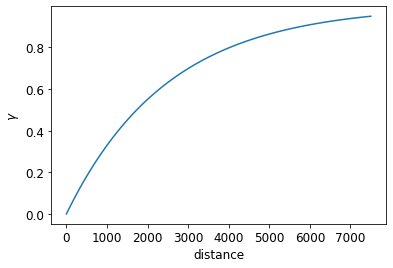

In [43]:
pst_helper.grid_geostruct.plot()

2020-12-17 08:22:32.213803 starting: building prior covariance matrix


C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

2020-12-17 08:22:37.745670 saving prior covariance matrix to file template_history\prior_cov.jcb
2020-12-17 08:22:40.158354 finished: building prior covariance matrix took: 0:00:07.944551


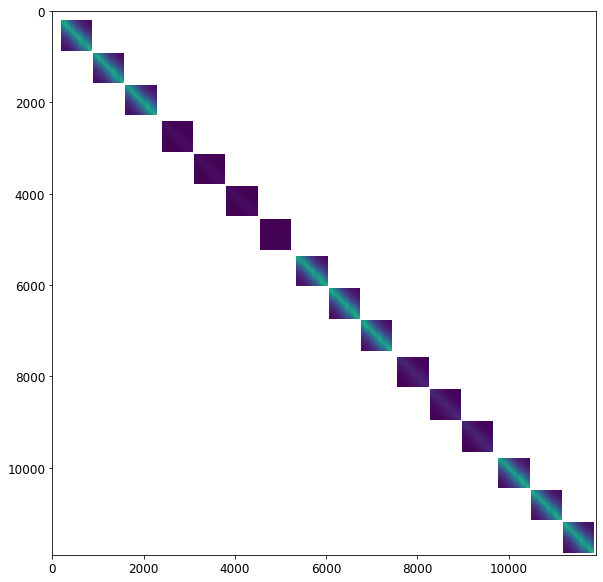

In [44]:
if pst_helper.pst.npar < 35000: #if you have more than about 35K pars, the cov matrix becomes hard to handle
    # build out the full cov matrix and write it to a compressed binary file
    cov = pst_helper.build_prior(fmt="coo",filename=os.path.join(pst_helper.new_model_ws,"prior_cov.jcb"))
    # mask for plotting
    cov = np.ma.masked_where(cov.x==0,cov.x)
    try:
        fig = plt.figure(figsize=(10,10))
        ax = plt.subplot(111)
        ax.imshow(cov)
        plt.show()
    except:
        pass

That's it: a full geostatistically-correlated block-diagonal covariance matrix.  Let's take a moment to soak that up!

### now we can make a draw from the prior parameter covariance matrix to form a prior parameter ensemble

The `pst_helper.draw()` method is very efficient, especially when the number of parameters is >35K.  It avoids forming the full cov matrix and instead operates block by block and, for grid-scale parameters, switches to 2-D spectral simulation.  

In [45]:
pe = pst_helper.draw(300)

2020-12-17 08:22:53.783159 starting: drawing realizations
building diagonal cov
processing  name:grid_geostruct,nugget:0.0,structures:
name:var1,contribution:1.0,a:2500.0,anisotropy:1.0,bearing:0.0

working on pargroups ['gr_hk3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
working on pargroups ['gr_vka3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
working on pargroups ['gr_ss3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
working on pargroups ['gr_sy3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
working on pargroups ['gr_prsity3']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
working on pargroups ['gr_hk4']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
working on pargroups ['gr_vka4']
build cov matrix
done
getting diag var cov 705
scaling full cov by diag var cov
working on 

C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\ProgramData\Miniconda3\envs\pyclass\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

processing  name:temporal_list_geostruct,nugget:0.0,structures:
name:var1,contribution:1.0,a:180.0,anisotropy:1.0,bearing:0.0

working on pargroups ['welflux']
build cov matrix
done
getting diag var cov 25
scaling full cov by diag var cov
adding remaining parameters to diagonal
2020-12-17 08:23:06.192658 finished: drawing realizations took: 0:00:12.409499


You can see that parameters are treated in parameter group (`pargp`) blocks for this ensemble generation. 

Always a good idea to inspect the parameter ensemble for reasonableness! Can do via slicing and dicing...

In [46]:
pe.iloc[-10:-5,:10]

return type uncaught, losing Ensemble type, returning DataFrame


,hk3000000,hk3000001,hk3000002,hk3000003,hk3000004,hk3000005,hk3000006,hk3000007,hk3000008,hk3000009
290,0.439962,0.536233,0.643571,0.774028,1.378526,1.640484,1.432491,1.708071,2.729541,2.378211
291,0.276085,0.255144,0.327047,0.304071,0.503279,0.773715,0.623258,1.057775,1.115006,1.229895
292,2.404401,1.833168,1.860183,2.171645,2.261154,2.891853,2.350322,3.618405,3.423168,4.632814
293,0.929303,1.025837,1.034193,1.061539,1.235716,1.183130,0.792057,0.524294,0.567562,0.897749
294,3.447750,3.718966,2.523729,3.762894,3.409835,1.719584,1.256587,1.361986,0.951743,0.661561


Let's look at parameters by groups

<Figure size 576x756 with 0 Axes>

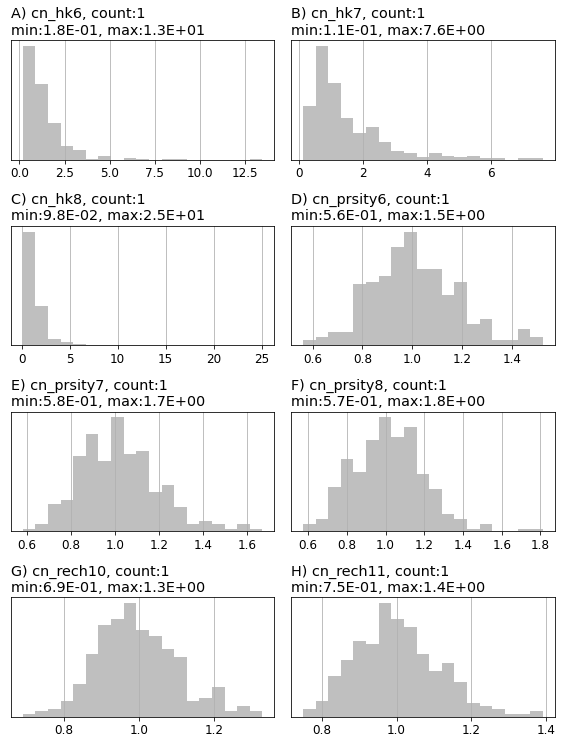

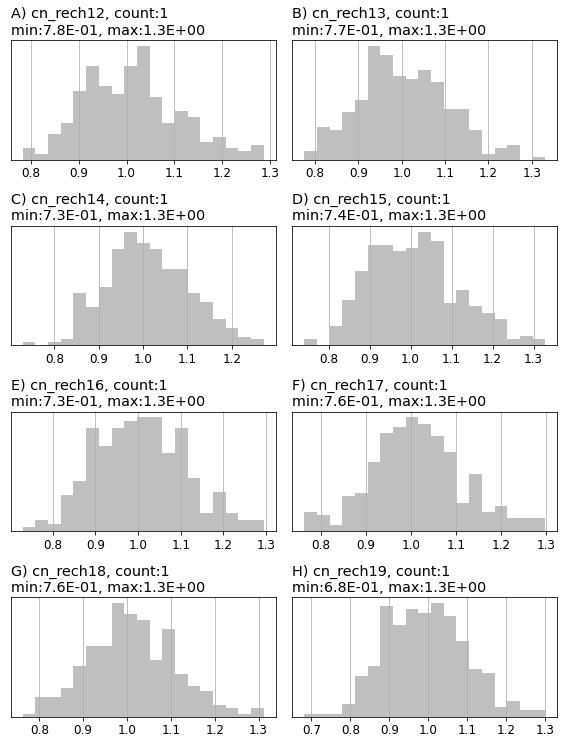

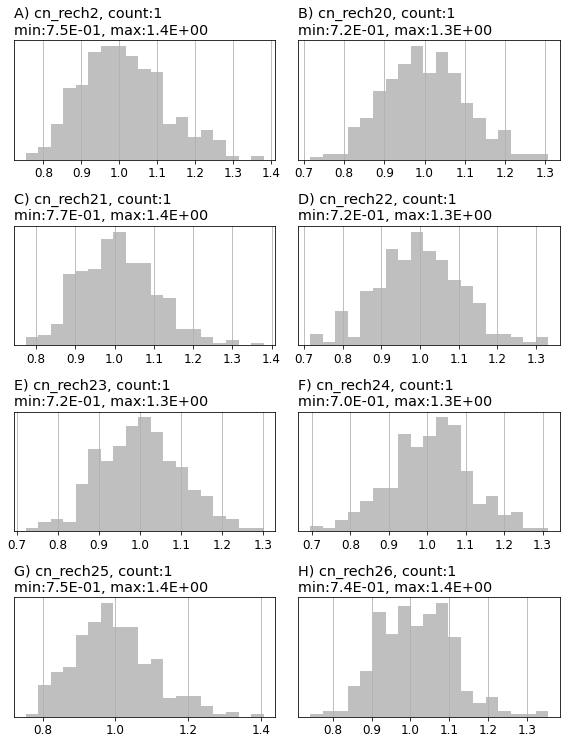

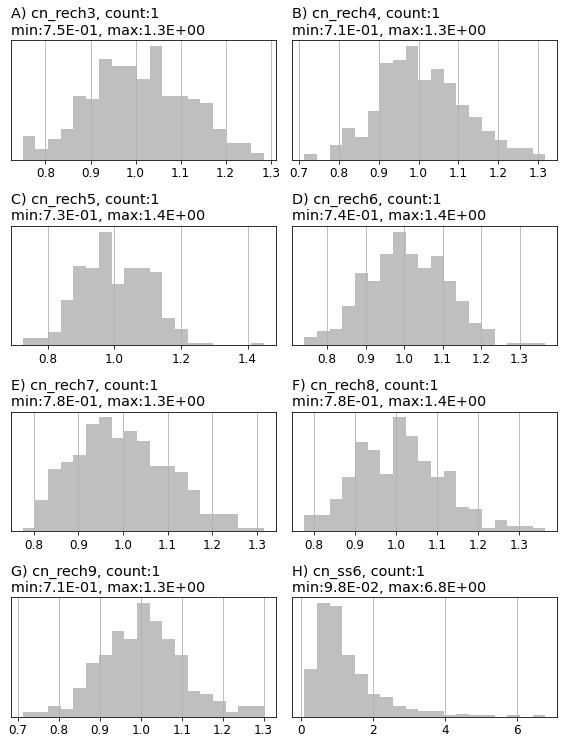

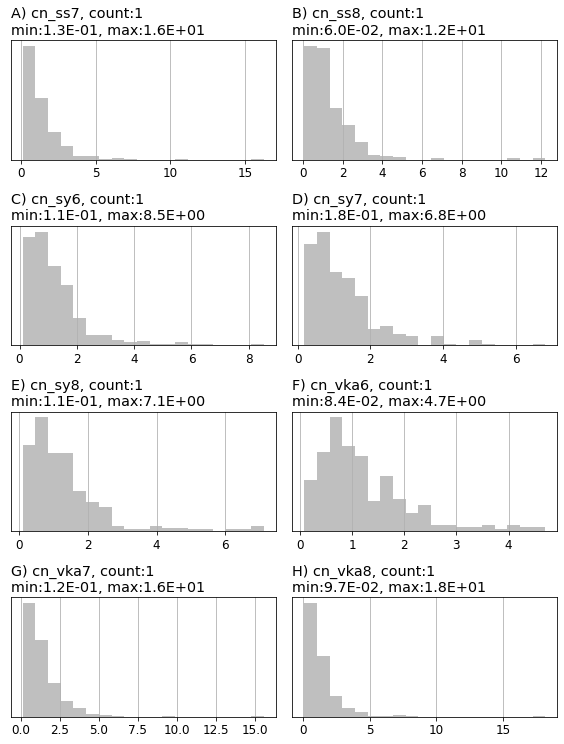

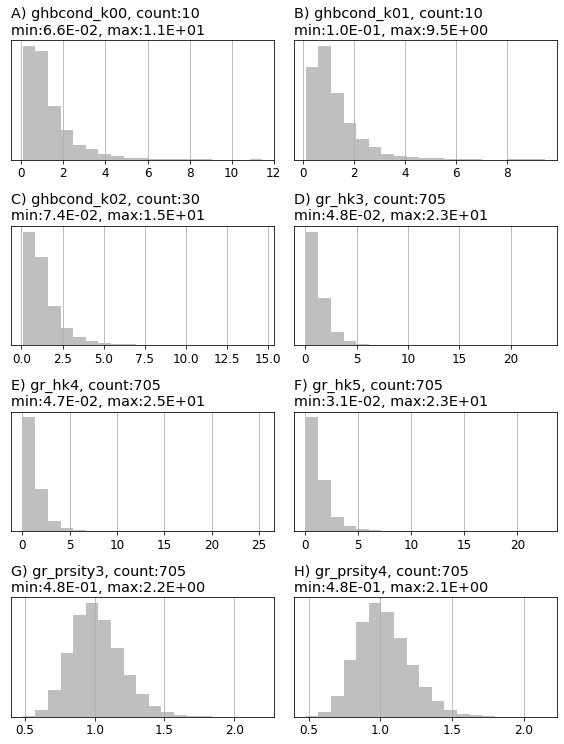

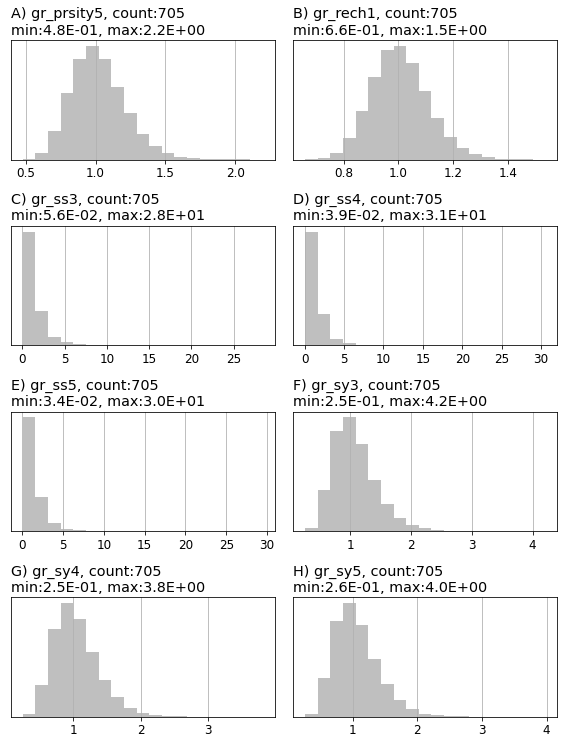

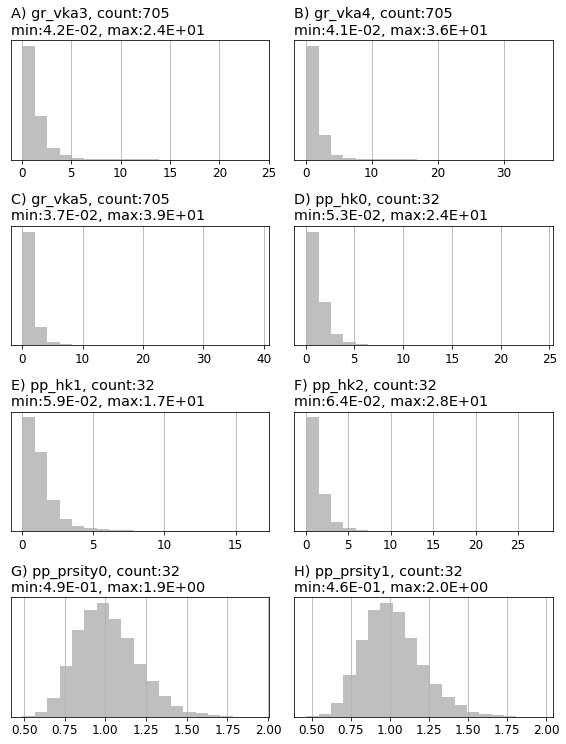

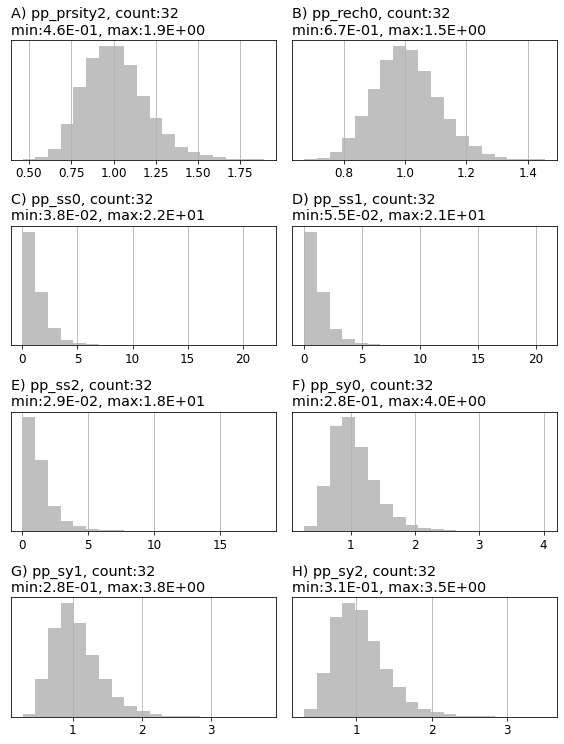

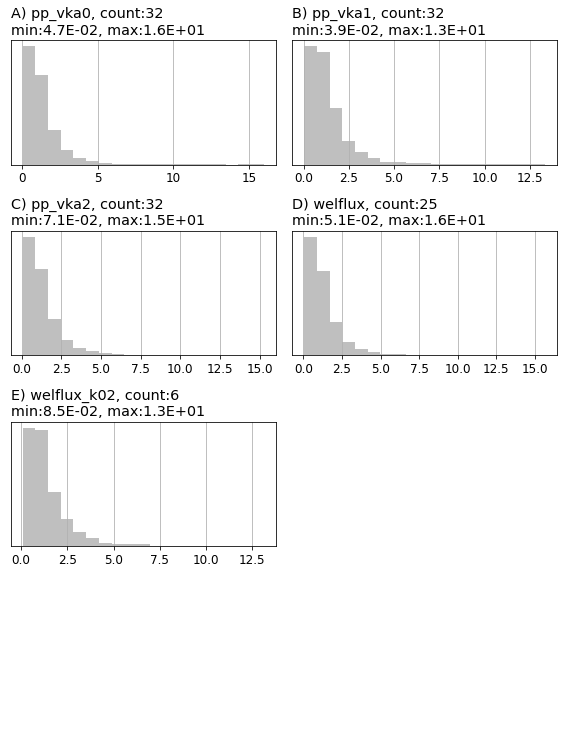

In [47]:
par = pst_helper.pst.parameter_data
pyemu.plot_utils.ensemble_helper(pe,plot_cols=par.groupby("pargp").groups,bins=20)
plt.show()

Thoughts? Do these look reasonable? We see log-normal distributions for log-transformed parameters, e.g., hk... looking good!

Now we need to enforce parameter bounds and save this ensemble for later

In [48]:
pe.enforce()  # always a good idea!
pe.to_binary(os.path.join(pst_helper.new_model_ws,"prior.jcb"))
pst_helper.pst.write(os.path.join(pst_helper.m.model_ws,nam_file.replace(".nam",".pst")))

noptmax:0, npar_adj:11913, nnz_obs:7272


### Set forecast names - just a few for FOSM later

In [49]:
obs = pst_helper.pst.observation_data
dts = pd.to_datetime(pst_helper.m.start_datetime) + pd.to_timedelta(np.cumsum(pst_helper.m.dis.perlen.array),unit='d')
dts_str = list(dts.map(lambda x: x.strftime("%Y%m%d")).values)
dry_dt = dts_str[dry_kper]
print(dry_dt)
swgw_forecasts = obs.loc[obs.obsnme.apply(lambda x: "fa" in x and ("hw" in x or "tw" in x) and dry_dt in x),"obsnme"].tolist()
#print(swgw_forecasts)
hds_fore_name = "hds_00_{0:03d}_{1:03d}_{2:03d}".format(int(pst_helper.m.nrow/3),int(pst_helper.m.ncol/10)
                                                       ,dry_kper)
print(hds_fore_name)
hds_forecasts = obs.loc[obs.obsnme.apply(lambda x: hds_fore_name in x),"obsnme"].tolist()
forecasts = swgw_forecasts
forecasts.extend(hds_forecasts)
forecasts.append("part_time")
forecasts.append("part_status")
pst_helper.pst.pestpp_options["forecasts"] = forecasts
forecasts

20171001
hds_00_013_002_021


['fa_hw_20171001',
 'fa_tw_20171001',
 'hds_00_013_002_021',
 'part_time',
 'part_status']

In [50]:
pst_helper.pst.write(os.path.join(pst_helper.m.model_ws,nam_file.replace(".nam",".pst")))

noptmax:0, npar_adj:11913, nnz_obs:7272


### "This is not the python command you are looking for"

In [51]:
prep_deps.prep_forecasts()

                                obsnme      obsval  weight  obgnme  extra
obsnme                                                                   
fa_hw_20171001          fa_hw_20171001   43.196000     1.0   flaqx    NaN
fa_tw_20171001          fa_tw_20171001  516.806000     1.0   flaqx    NaN
hds_00_013_002_021  hds_00_013_002_021   34.856041     1.0     hds    NaN
part_time                    part_time  283.911746     1.0  obgnme    NaN
part_status                part_status    2.000000     1.0  obgnme    NaN
                        obsval
obsnme                        
fa_hw_20170913     -207.803646
fa_tw_20170913      -12.324782
hds_00_013_002_621   35.433281
part_time           547.242400
part_status           2.000000
                                obsnme      obsval  weight  obgnme  extra
obsnme                                                                   
fa_hw_20171001          fa_hw_20171001 -207.803646     1.0   flaqx    NaN
fa_tw_20171001          fa_tw_20171001  -12

In [52]:
pyemu.os_utils.run("pestpp-ies {0}".format(nam_file.replace(".nam",".pst")),cwd=pst_helper.m.model_ws)

In [53]:
pst = pyemu.Pst(os.path.join(pst_helper.m.model_ws,"freyberg.pst"))
pst.res.loc[pst.forecast_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
fa_hw_20171001,fa_hw_20171001,flaqx,43.196000,43.196100,-1.000000e-04,1.0
fa_tw_20171001,fa_tw_20171001,flaqx,516.806000,516.806000,0.000000e+00,1.0
hds_00_013_002_021,hds_00_013_002_021,hds,34.856041,34.856041,4.101537e-10,1.0
part_time,part_time,obgnme,283.911746,283.911740,6.054438e-06,1.0
part_status,part_status,obgnme,2.000000,2.000000,0.000000e+00,1.0


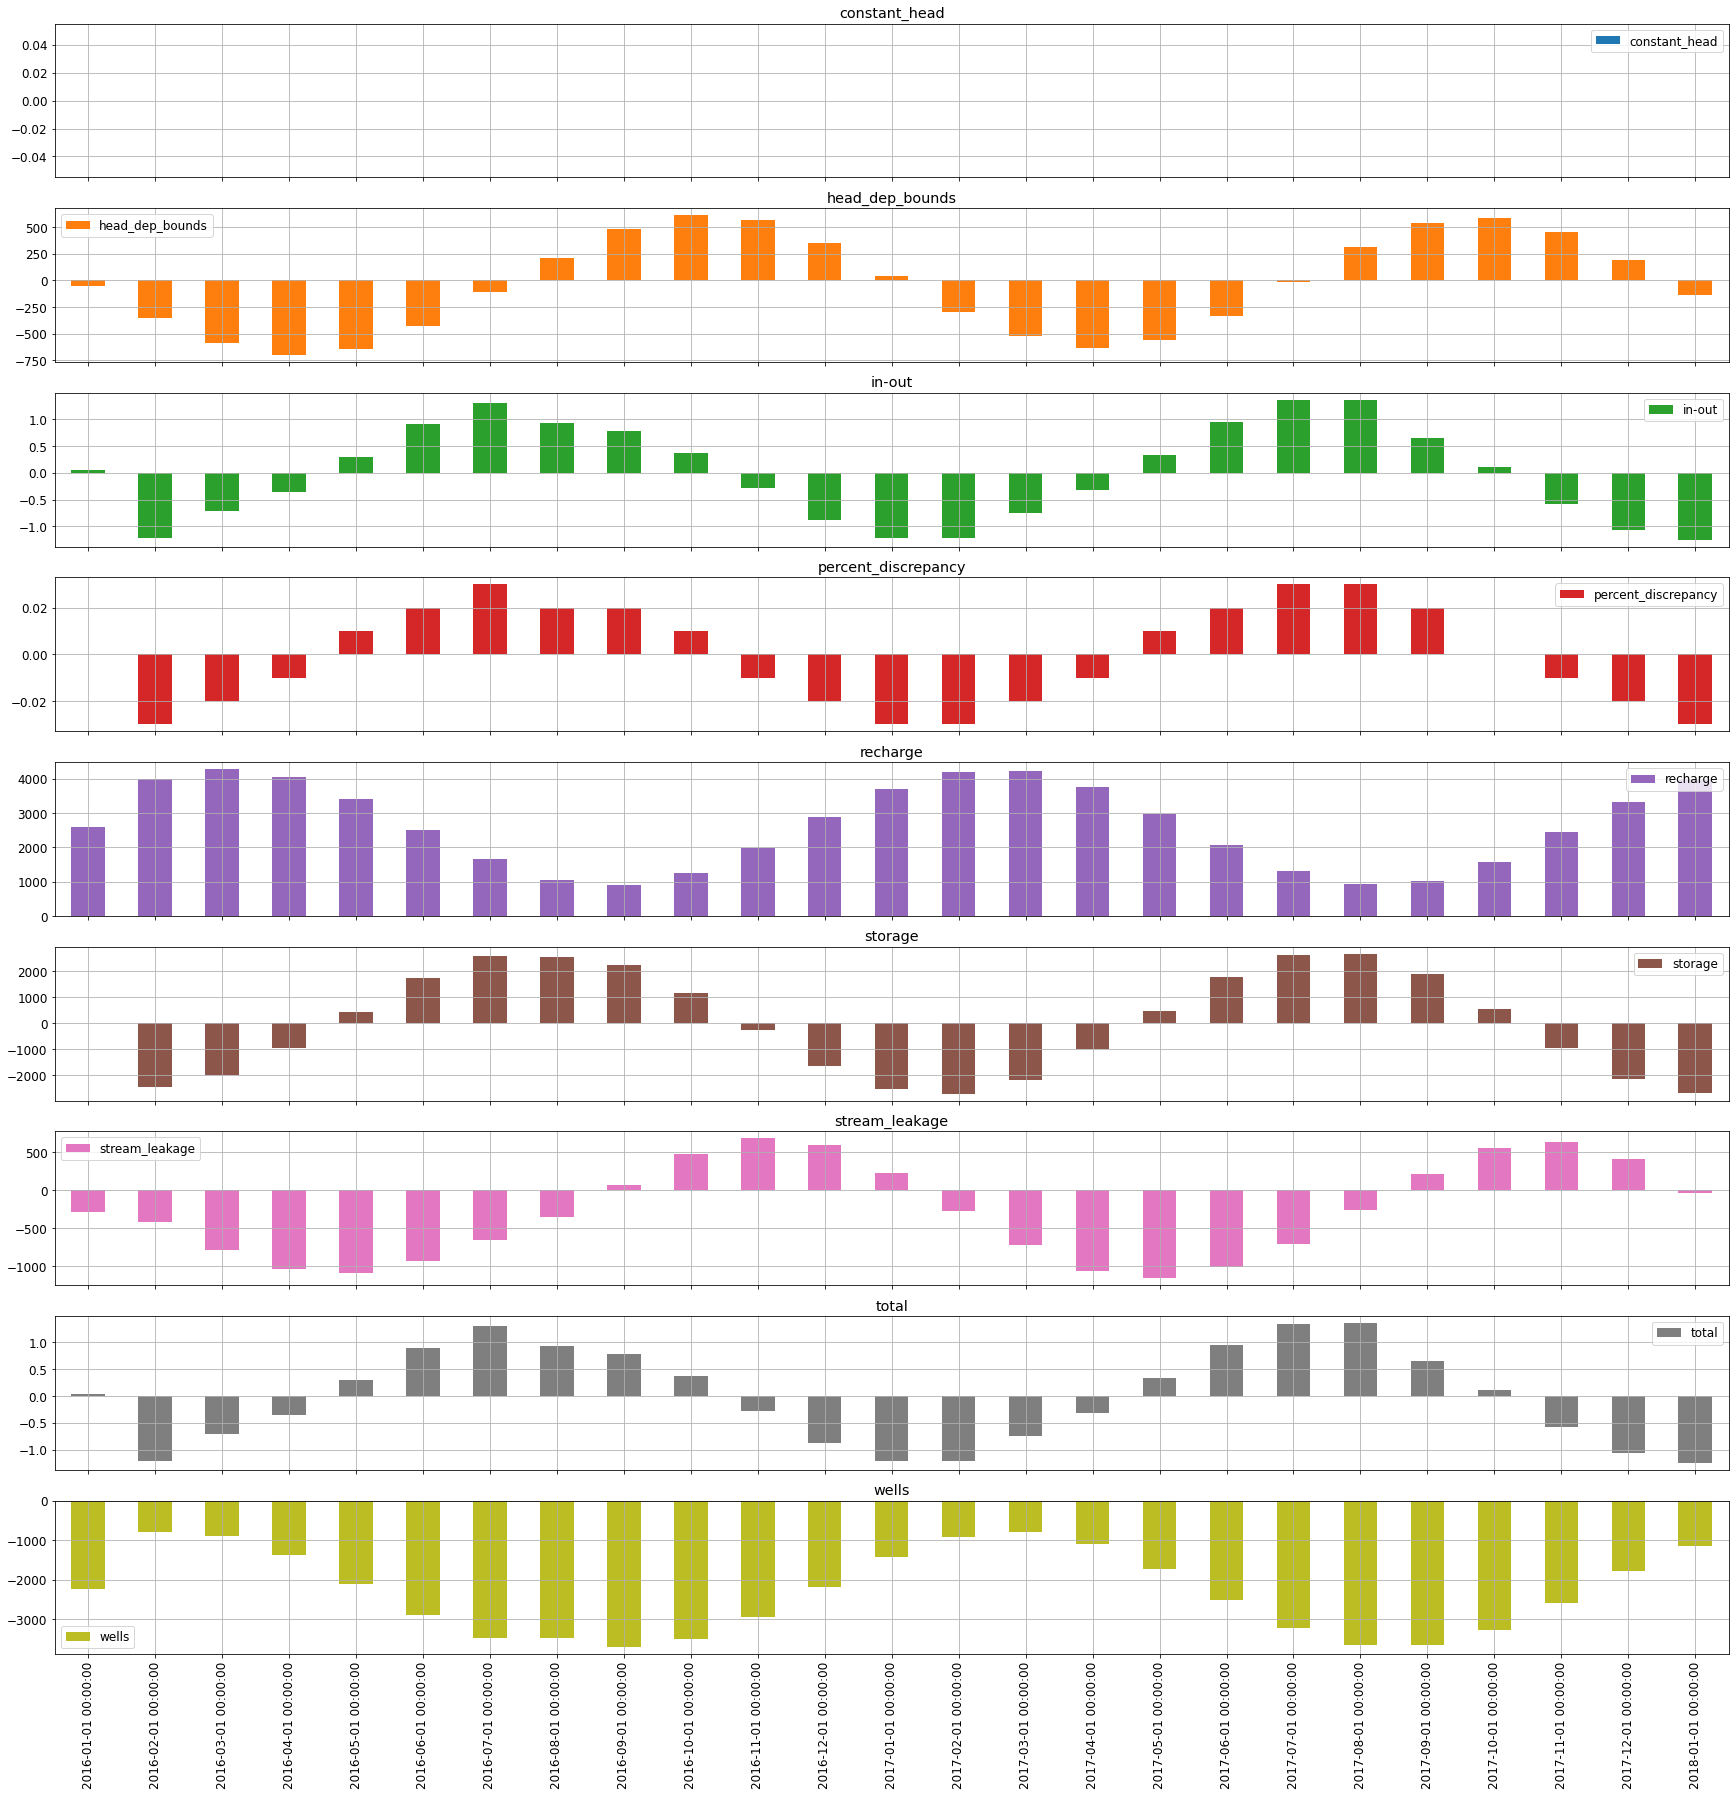

In [54]:
lst = flopy.utils.MfListBudget(os.path.join(pst_helper.m.model_ws,nam_file.replace(".nam",".list")))
df = lst.get_dataframes(diff=True,start_datetime=pst_helper.m.start_datetime)[0]
df.plot(kind="bar",figsize=(30,30), grid=True,subplots=True)
plt.show()

### Demystifying the multiplier parameter process!

In [55]:
def run_and_plot_hk(real):
    # replace the par values in the control file
    pst.parameter_data.loc[:,"parval1"] = pe.loc[real,pst.par_names]
    # save the updated control file
    pst.write(os.path.join(pst_helper.new_model_ws,"test.pst"))
    # run a single model run to generate the multipliers and inputs
    pyemu.os_utils.run("pestpp-ies.exe test.pst",cwd=pst_helper.new_model_ws)

    # load the arrays
    base_arr = np.log10(np.loadtxt(os.path.join(pst_helper.new_model_ws,"arr_org","hk_Layer_1.ref")))
    pp_arr = np.log10(np.loadtxt(os.path.join(pst_helper.new_model_ws,"arr_mlt","hk0.dat_pp")))
    gr_arr = np.log10(np.loadtxt(os.path.join(pst_helper.new_model_ws,"arr_mlt","hk3.dat_gr")))
    cn_arr = np.log10(np.loadtxt(os.path.join(pst_helper.new_model_ws,"arr_mlt","hk6.dat_cn")))
    in_arr = np.log10(np.loadtxt(os.path.join(pst_helper.new_model_ws,"hk_Layer_1.ref")))
    arrs = [base_arr,cn_arr,pp_arr,gr_arr,in_arr]
    
    labels = ["log10 base","log10 constant","log10 pilot points","log10 grid","log10 resulting input"]
    # mask with ibound
    ib = m.bas6.ibound[0].array
    for i,arr in enumerate(arrs):
        arr[ib==0] = np.NaN
    
    fig,axes = plt.subplots(1,5,figsize=(20,5))
    
    # work out the multiplier min and max
    vmin1 = min([np.nanmin(a) for a in arrs[1:-1]])
    vmax1 = max([np.nanmax(a) for a in arrs[1:-1]])
    
    # plot each array
    for i,(ax,arr,label) in enumerate(zip(axes,arrs,labels)):
        if i not in [0,len(arrs)-1]:  
            cb = ax.imshow(arr,vmin=vmin1,vmax=vmax1)
        else:
            cb = ax.imshow(arr)
        ax.set_title(label)
        ax.set_yticks([])
        ax.set_xticks([])
        plt.colorbar(cb,ax=ax)
    plt.tight_layout()
    plt.show()


noptmax:0, npar_adj:11913, nnz_obs:7272


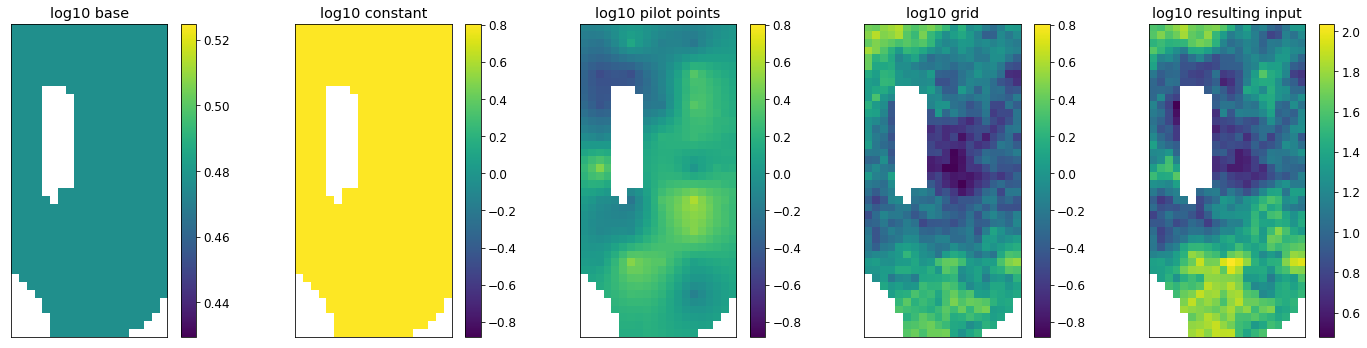

In [56]:
run_and_plot_hk(5)

noptmax:0, npar_adj:11913, nnz_obs:7272


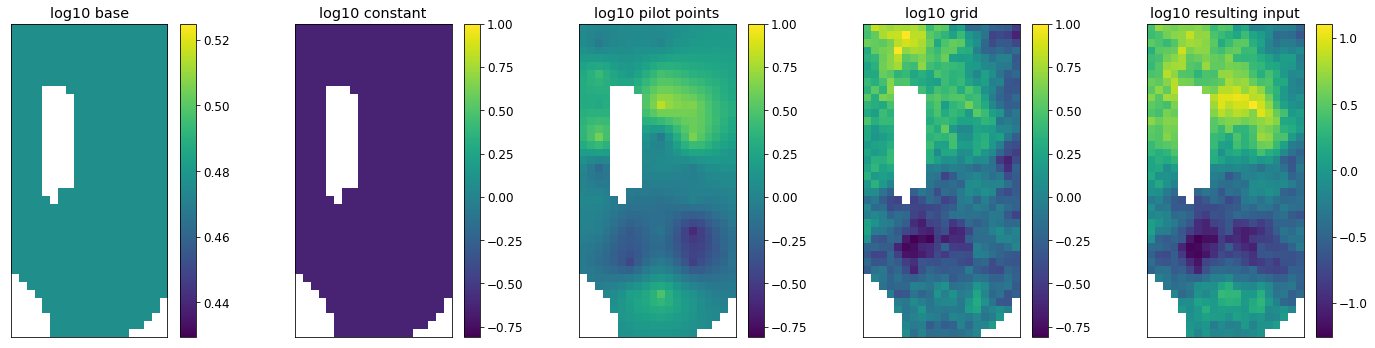

In [57]:
run_and_plot_hk(10)